In [30]:
from pysad.evaluation import AUROCMetric
from pysad.models import xStream, ExactStorm, HalfSpaceTrees, IForestASD, KitNet, KNNCAD, LODA, LocalOutlierProbability, \
    MedianAbsoluteDeviation, RelativeEntropy, RSHash, RobustRandomCutForest, StandardAbsoluteDeviation
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import anomaly

import numpy as np

import matplotlib.pyplot as plt


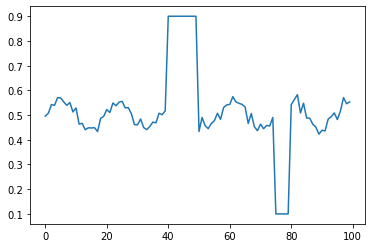

In [31]:
# X = [0.5, 0.45, 0.43, 0.44, 0.445, 0.45, 0.0]
# X = np.random.binomial(10,0.5,1000)/10
dur = 100
f0 = 1
fs = 3
t = np.arange(dur)
sinusoid = np.sin((t * f0/fs) )
noise = np.random.normal(0,0.3,dur)
X = (sinusoid + noise + 8)/16
Y = np.zeros(len(X))

# Drop values high and label Y
X[40:50] = 0.9
Y[40:50] = 1

# Drop values low
X[75:80] = 0.1
Y[75:80] = 1

hst = anomaly.HalfSpaceTrees(
     n_trees=5,
     height=3,
     window_size=3,
     seed=42
 )
auc = metrics.ROCAUC()
for x in X[:3]:
    hst = hst.learn_one({'x': x})  # Warming up

score_list = []
for x,y in zip(X,Y):
    features = {'x': x}
    hst = hst.learn_one(features)
    score = hst.score_one(features)
    score_list.append(score)
    auc = auc.update(y, score)
#     print(f'Anomaly score for x={x:.3f}: {score:.3f}')
# print(score_list)

# Dataset
fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
plt.plot(X)
# ax.plot(np.arange(1,1001),X)
plt.show()


## PySad

In [32]:
model = xStream()  # Init model.
calibrator = ConformalProbabilityCalibrator(windowed=True, window_size=300)
streaming_data = X  # Get streamer.

xstream_count = 0
xstream_score = []

for x in X:
        anomaly_score = model.fit_score_partial(x)  # Fit to an instance x and score it.

        calibrated_score = calibrator.fit_transform(anomaly_score)  # Fit & calibrate score.
        xstream_score.append(calibrated_score)
        # Output if the instance is anomalous.
        if calibrated_score > 0.95:
            xstream_count += 1# If probability of being normal is less than 5%.
        # print(f"Alert: {i}th data point is anomalous.")
print(f'Anamolies detected: {xstream_count}')

Anamolies detected: 4


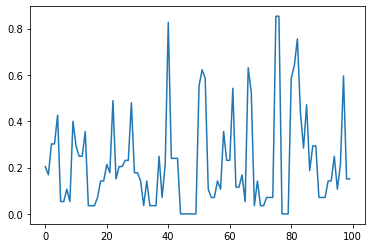

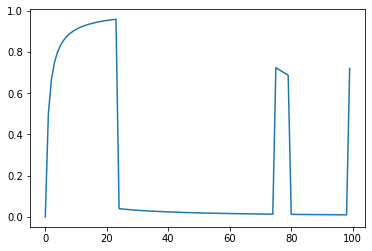

In [33]:
plt.figure()
plt.plot(score_list)
plt.figure()
plt.plot(xstream_score)


In [59]:
model_classes = {
        ExactStorm.__class__.__name__: { "model": ExactStorm(),
                                       "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                       "count": 0,
                                       "scores": [],
                                        "metric": AUROCMetric()},
        IForestASD.__class__.__name__: { "model": xStream(),
                                           "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                           "count": 0,
                                           "scores": [],
                                           "metric": AUROCMetric()},
        KitNet.__class__.__name__: { "model":KitNet(),
                                       "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                       "count": 0,
                                       "scores": [],
                                       "metric": AUROCMetric()},
        # KNNCAD.__class__.__name__: {"model":KNNCAD(10),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "count": 0,
        #                                "scores": [],
        #                                "metric": AUROCMetric()},
        LODA.__class__.__name__: { "model":LODA(),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        # LocalOutlierProbability.__name__: { "model":LocalOutlierProbability(False), # SUPERVISED MODEL
        #                    "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                    "count": 0,
        #                    "scores": [],
        #                     "metric": AUROCMetric()},
        MedianAbsoluteDeviation.__name__: { "model":MedianAbsoluteDeviation(),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        RelativeEntropy.__name__: { "model":RelativeEntropy(0.0, 1.0),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        RSHash.__class__.__name__: { "model":RSHash(feature_mins=[0.0], feature_maxes=[1.0]),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        StandardAbsoluteDeviation.__name__: { "model":StandardAbsoluteDeviation(),
                                   "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                   "count": 0,
                                   "scores": [],
                                    "metric": AUROCMetric()},
        xStream.__class__.__name__: {"model": xStream(),
                                       "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                       "count": 0,
                                       "scores": [],
                                        "metric": AUROCMetric()},
        RobustRandomCutForest.__class__.__name__: {"model": RobustRandomCutForest(),
                                   "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                   "count": 0,
                                   "scores": [],
                                    "metric": AUROCMetric()},
        HalfSpaceTrees.__name__: { "model": HalfSpaceTrees([0.0],[1.0]),
                                   "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                   "count": 0,
                                   "scores": [],
                                    "metric": AUROCMetric()},
    }
for key, props in model_classes.items():
    for x,y in zip(np.reshape(X, (-1, 1)),Y):
        anomaly_score = props["model"].fit_score_partial(x) # Fit to an instance x and score it.
        if anomaly_score:
            anomaly_score = props["calibrator"].fit_transform(np.reshape(anomaly_score, (-1,1)))

        props["metric"].update(y, anomaly_score)

        props["scores"].append(anomaly_score)
        # Output if the instance is anomalous.
        if anomaly_score > 0.90:
            props["count"] += 1# If probability of being normal is less than 5%.
            # print(f"Alert: {i}th data point is anomalous.")
print("Done")


Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Done


C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

ExactStorm - ROC: 0.859607843137255 & Detected Anomalies 11
IForestASD - ROC: 0.6015686274509804 & Detected Anomalies 14
KitNet - ROC: 0.5 & Detected Anomalies 0
LODA - ROC: 0.6415686274509804 & Detected Anomalies 6
MedianAbsoluteDeviation - ROC: 0.06901960784313728 & Detected Anomalies 5
RelativeEntropy - ROC: 0.5 & Detected Anomalies 0
ABCMeta - ROC: 1.0 & Detected Anomalies 3
StandardAbsoluteDeviation - ROC: 0.07411764705882355 & Detected Anomalies 14
xStream - ROC: 0.6007843137254901 & Detected Anomalies 14
RobustRandomCutForest - ROC: 0.13333333333333333 & Detected Anomalies 3
HalfSpaceTrees - ROC: 0.8564705882352941 & Detected Anomalies 15
River - HST ROCAUC: 0.44


Text(0.5, 1.0, 'Detection Method: River HST')

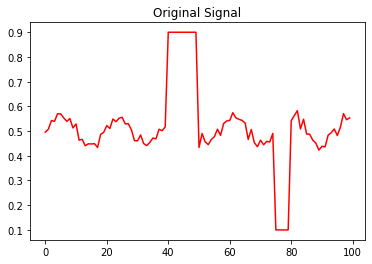

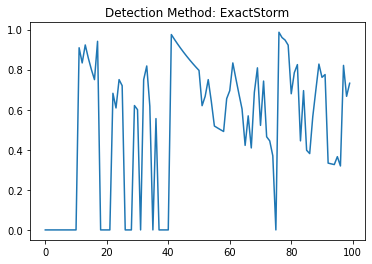

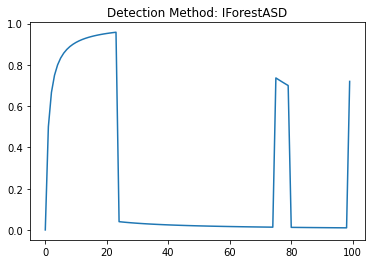

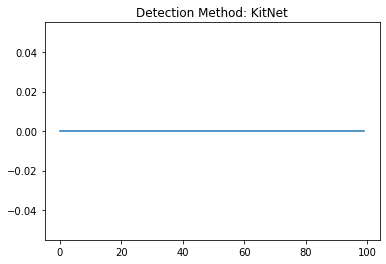

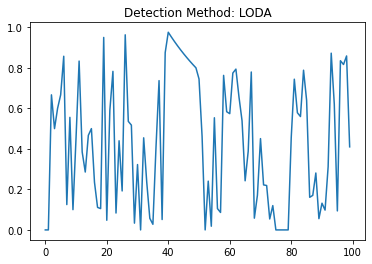

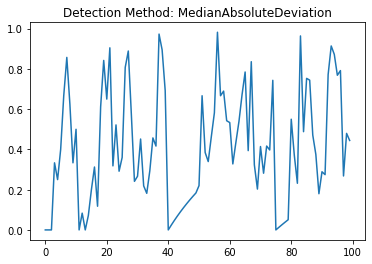

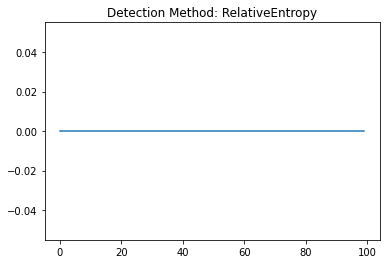

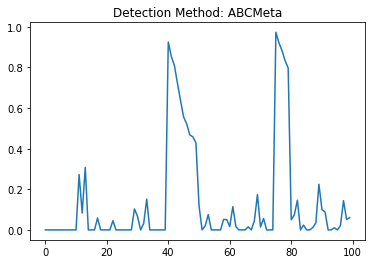

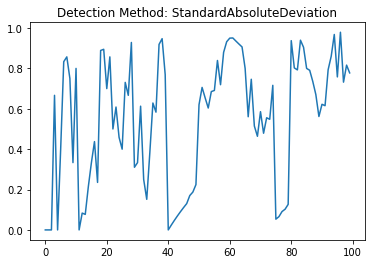

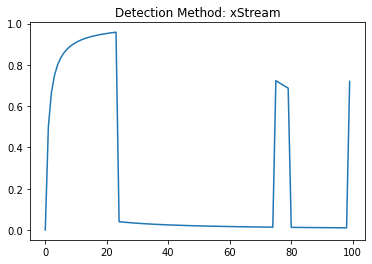

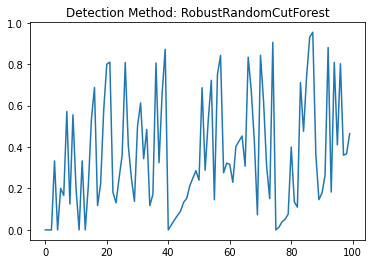

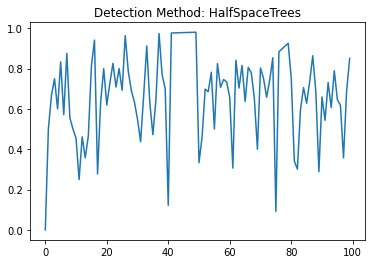

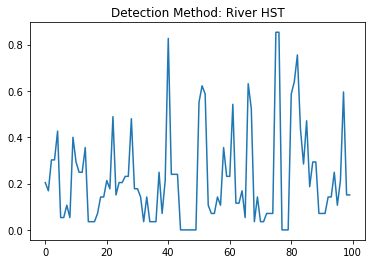

In [60]:
fig = plt.figure()
plt.plot(X,'r')
plt.title("Original Signal")
for key, props in model_classes.items():
    print(f'{key} - ROC: {props["metric"].get()} & Detected Anomalies {props["count"]}')
print(f'River - HST {auc}')
for key, props in model_classes.items():
    plt.figure()
    plt.plot(props["scores"],label=key)
    plt.title(f"Detection Method: {key}")

plt.figure()
plt.plot(score_list)
plt.title("Detection Method: River HST")